# DATA SCIENCE SESSIONS VOL. 3
### A Foundational Python Data Science Course
## Session 20: Introduction to Decision Trees for classification and regression problems.

[&larr; Back to course webpage](https://datakolektiv.com/)

Feedback should be send to [goran.milovanovic@datakolektiv.com](mailto:goran.milovanovic@datakolektiv.com). 

These notebooks accompany the DATA SCIENCE SESSIONS VOL. 3 :: A Foundational Python Data Science Course.

![](../img/IntroRDataScience_NonTech-1.jpg)

### Lecturers

[Goran S. Milovanović, PhD, DataKolektiv, Chief Scientist & Owner](https://www.linkedin.com/in/gmilovanovic/)

[Aleksandar Cvetković, PhD, DataKolektiv, Consultant](https://www.linkedin.com/in/alegzndr/)

[Ilija Lazarević, MA, DataKolektiv, Consultant](https://www.linkedin.com/in/ilijalazarevic/)

![](../img/DK_Logo_100.png)

***

In [1]:
### --- Setup - importing the libraries

# - supress those annoying 'Future Warning'
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

# - data
import numpy as np
import pandas as pd

# - os
import os

# - ml
import statsmodels.api as sm
import statsmodels.formula.api as smf
from statsmodels.stats.outliers_influence import variance_inflation_factor

from sklearn.metrics import r2_score, accuracy_score, f1_score, classification_report, confusion_matrix

from sklearn import tree
from sklearn.tree import DecisionTreeClassifier, DecisionTreeRegressor
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.preprocessing import LabelEncoder

# - visualization
import matplotlib.pyplot as plt
import seaborn as sns

import collections

# - directory tree
data_dir = os.path.join(os.getcwd(), '_data')

# Decision Trees

Decision trees are powerful and widely used models in machine learning and data science. They provide a systematic and intuitive approach to solving classification and regression problems. Decision trees mimic human decision-making processes by breaking down complex problems into a sequence of simpler decisions or conditions.

At its core, a decision tree is a flowchart-like structure that consists of nodes and branches. Each node represents a feature or attribute, and the branches represent the possible values or outcomes of that feature. The tree structure starts with a root node and branches out into intermediate nodes, known as internal nodes, and leaf nodes, which represent the final decision or prediction.

Example of decision tree would be:

![](./_img/decision_tree_example.png)


The important thing is that there is a goal in mind e.g. to buy a car. Then, based on options and decisions, the path to the goal is defined with it.

In general, decision trees are used in decision analysis to help define best strategy to reach given goal.

In machine learning, and particularly in supervised learning, we use decision trees based on the data where goal was already reached, successfully or unsuccessfully. In that sense, what we are trying to do is to reverse-engineer the whole process, and based on data provided come up with the tree-like structure of rules, that can support the evidence in data.

Let's take a quick look at how we create decision trees with `sklearn` library. 

For this session we are going to use *Titanic* dataset, one of the few data sets that are widely known because it contains data of all Titanic survivors. For each of the passengers there is a set of characteristics and a flag variable *Survived* that marks if the passenger survived or not. As you can imagine, this is going to be classification problem at hand, and we will start by showing how decision trees can be used in classification.

In [2]:
df_train = pd.read_csv(os.path.join(data_dir, 'Titanic_train.csv'))

In [3]:
df_train.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


Let's for the sake of quick overview run next cell without going into details:

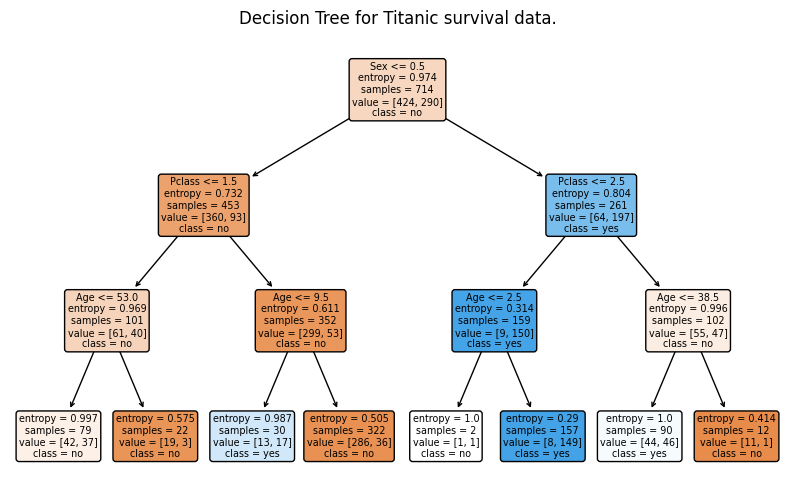

In [4]:
# select few predictors
df_train = df_train[['Survived', 'Pclass', 'Sex', 'Age']]

# encode binary categorical variable
df_train['Sex'] = df_train['Sex'].replace({'male': 0, 'female': 1})

# drop observations with NaN values
df_train = df_train.dropna()

# create DT
dc = DecisionTreeClassifier(max_depth=3, criterion='entropy')
# fit the DT
X, y = df_train.drop(columns=['Survived']), df_train[['Survived']]
dc.fit(X, y)

# plot the DT
fig = plt.figure(figsize=(10, 6))
_ = tree.plot_tree(dc, 
                   feature_names=dc.feature_names_in_,  
                   class_names=['no', 'yes'],
                   filled=True, 
                   rounded=True)
plt.gca().set_title('Decision Tree for Titanic survival data.');

As you can see, there is 15 nodes in this tree. First node at the top is called tree root. Nodes at the bottom are called leafs. Each node contains 5 rows of information, and most of these are not that important at the moment. First row in each node shows the name of the predictor that algorithm used for creating the logical expression. Based on the truth of this expression does algorithm spawn another tree branch and node. 

But how does algorithm decide which predictor and value to use for each node's logical expression?

Here we have to make a short detour into **Information Theory** and describe important concepts that will make everything clear. And remember, we are still at classification problems. Later on we will move to a regression ones.

## Information theory

Information theory is a discipline that focuses on the mathematical study of information, its transmission, storage, and processing. Developed by Claude Shannon in the mid-20th century, information theory provides a quantitative framework to measure the amount of information contained in a message or data. It offers insights into how efficiently information can be encoded, transmitted, and decoded, while accounting for factors such as noise and uncertainty.

At the core of information theory is the concept of entropy, which quantifies the uncertainty or randomness in a set of data. Shannon's entropy measures the average amount of information needed to identify an outcome in a dataset. By analyzing the distribution and probabilities of outcomes, entropy enables us to understand the optimal encoding and compression schemes for efficient data representation. 

Information theory has found applications in various fields, including telecommunications, data compression, cryptography, and machine learning, providing a solid mathematical foundation for understanding and manipulating information in a quantitative manner.

The important concept that we are introducing here, for the purpose of creating decision trees is **entropy**. As already stated, it **quantifies the uncertainty or randomness in a set of data**.

Let us, in parallel, define **information content**, and let us view it from the perspective of a certain event happening. As you can already remember, we talked about event term when we spoke about probability. And this is exactly how we are going to approach describing these concepts.


### Information and Probability

For the sake of clear explanation, let's imagine each day at noon, you look through your windows, at the sky. Is it day or night? Day most probably. As a matter of fact, it is certainly day (except there is an eclipse). And since this surely must be a day, and not night, how informative is this insight to you? You could just as easily guessed that it is a day, and you would be right. Probability of being a day at noon is 99.99% (or something very close). 

This is very intuitive, right? If something is almost certain, than we are probably used to it, and that information is of low value to us. We can say it has a low information content. And randomness of this event is very low, right? 

If we sum this up, we can say that **event with high probability has low information content** (*self-information*).

In the scenario where there was an eclipse, it would be 'night', right? And this would be something you would eagerly rush to tell your friends. Why? Because it is of great value i.e. high information content. And we all know that eclipse has very low probability. Let's imagine we do not have ways of knowing the exact day it will happen, because we do, at this day and age. But this is not the point. The point is, **event with low probability has high information content**.

### Information content

Apparently, there are few other assumptions that Claude Shannon introduced, while defining information content as a concept. And while you may think that information content should be defined as $\frac{1}{P(E)}$, where $E$ is an event, it is defined as:

$$ I(E) = \log_{2}{\frac{1}{P(E)}}.$$

Using highschool knowledge of logarighms, we can write this in another form:

$$I(E) = - \log_{2}\bigl({P(E)}\bigr).$$

But why **logarithm**? Well, one of the assumptions was that if there are two events, $A$ and $B$, and $P(A) > P(B)$, then $I(A) < I(B)$. This of course can be satisfied with using $\frac{1}{P(E)}$ as an expression of information content. 

However, another assumption is that if there are two independent events $A$ and $B$, information content of them both happening should be the sum of information contents of each of them happening, or $I(P(A, B)) = I(P(A)) + I(P(B))$. If we remember from the probability theory, for two indepentend events $A$ and $B$, we had that:

$$P(A\cap B) = P(A, B) = P(A)P(B).$$

Because of this, logarithm was a convenient function to use to express information content.

Now, let's define Python function that will return information content for event based on it's probability.


In [5]:
def self_information(p: float = .5):
    return -np.log2(p)

In [6]:
# Self-information of event with .5 probability
self_information(.5)

1.0

You could say, that if we flip a fair coin, the information content of result being Heads is 1.0. This is also the maximal randomness, right? We can't say what result is more probable, since both are equaly probable. And since randomness is at it's peak, we say that the entropy is also maximal.

What about we plot information content as a function of probability?

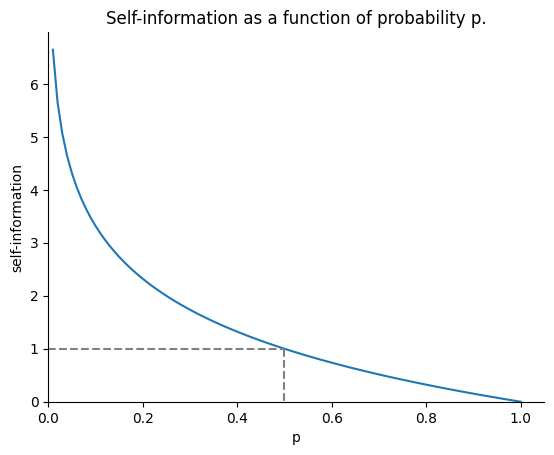

In [7]:
x = np.linspace(0.01, 1, 100)
y = self_information(x)
plt.plot(x, y)
sns.despine()
plt.xlabel('p')
plt.ylim(0)
plt.xlim(0)
plt.plot((.5, .5), (1, 0), '--', color='grey')
plt.plot((.0, .5), (1, 1), '--', color='grey')
plt.ylabel('self-information')
plt.title('Self-information as a function of probability p.');

Information of 5 independent throws (of fair coin), i.e. gettin sequence of results: **0 1 1 0 1**?

In [8]:
PH = .5
PT = .5

self_information(PT) + self_information(PH) + self_information(PH) + self_information(PT) + self_information(PT)

5.0

And what is an average information content for these throws

In [9]:
(3 * self_information(PH) + 2 * self_information(PT)) / 5

1.0

### Information Entropy

Now, what if we wanted to generalize above presented approach and define a way of getting the average information content for random variable at hand? 

Let's start with the descrete random variable.

If we have **p** as a vector of probabilities for each possible state of a random variable X, then average information content, also called **information entropy**, would be defined as:

$$H(X)=-\sum_i p_ilog_{2}p_i$$

Defining it for continous random variable is very similar:

$$H(X)=\int p(x)log_{2}p(x)dx$$

How about we define Python function that will return information entropy of a descrete random variable which vector of probabilities is defined as **p**.

In [10]:
def entropy_basic(p):
    return np.sum(p * self_information(p))

What is the information entropy of a random variable describing fair coin flip?

In [11]:
entropy_basic([1/2, 1/2])

1.0

And what about fair six-sided dice?

In [12]:
entropy_basic([1/6, 1/6, 1/6, 1/6, 1/6, 1/6])

2.584962500721156

And now, what about we plot entropy as a function of a probability of getting Heads in coin flip?

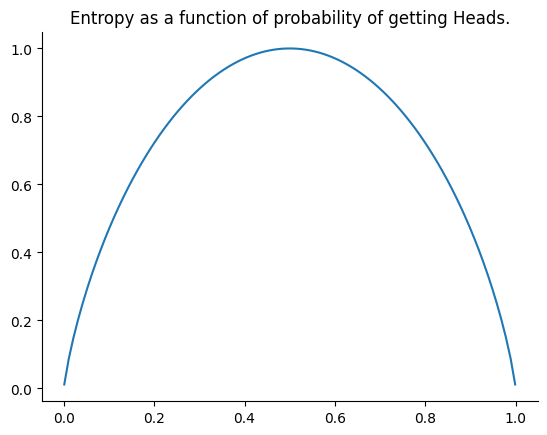

In [13]:
x = np.linspace(0.001, 0.999, 100)
y = list(map(entropy_basic, list(zip(x, 1-x))))
plt.plot(x, y)
sns.despine()
plt.title('Entropy as a function of probability of getting Heads.');


Wait wait, what happened here `list(map(entropy, list(zip(x, 1-x))))`?

Let's go step by step.

In [14]:
x[:10], (1-x)[:10]

(array([0.001     , 0.01108081, 0.02116162, 0.03124242, 0.04132323,
        0.05140404, 0.06148485, 0.07156566, 0.08164646, 0.09172727]),
 array([0.999     , 0.98891919, 0.97883838, 0.96875758, 0.95867677,
        0.94859596, 0.93851515, 0.92843434, 0.91835354, 0.90827273]))

In [15]:
list(zip(x, 1-x))[:10]

[(0.001, 0.999),
 (0.01108080808080808, 0.988919191919192),
 (0.021161616161616163, 0.9788383838383838),
 (0.031242424242424245, 0.9687575757575757),
 (0.041323232323232324, 0.9586767676767677),
 (0.0514040404040404, 0.9485959595959595),
 (0.06148484848484849, 0.9385151515151515),
 (0.07156565656565657, 0.9284343434343434),
 (0.08164646464646465, 0.9183535353535354),
 (0.09172727272727273, 0.9082727272727272)]

In [16]:
list(map(entropy_basic, list(zip(x, 1-x))[:10]))

[0.011407757737461138,
 0.08787596435469067,
 0.14791393481427534,
 0.20058479115485361,
 0.24832660995876613,
 0.292331543644311,
 0.3333112291872919,
 0.3717393976676705,
 0.4079542063302699,
 0.44220910087961685]

Now, let's try solving next problem. We have 12 balls, *blue* and *red*, and we have them ordered.

What is the information entropy of this group of balls in respect to the colors present?

We will define `DataFrame` to visualize this example:

In [17]:
df_balls = pd.DataFrame(['b', 'r', 'r', 'r', 'b', 'b', 'b', 'r', 'b', 'b', 'r', 'b']).reset_index().rename(columns={'index': 'num', 0: 'color'})

df_balls['num'] = df_balls['num'] + 1

df_balls['color_label'] = (df_balls['color'] == 'b').astype('int')

df_balls

,num,color,color_label
0,1,b,1
1,2,r,0
2,3,r,0
3,4,r,0
4,5,b,1
5,6,b,1
6,7,b,1
7,8,r,0
8,9,b,1
9,10,b,1


Let's redefine helper function that will take sequence of each observations class, i.e. `df_balls['color_label']`, and return probabilities for each class based on $MLE$.

In [18]:
def entropy(x):
    _, counts = np.unique(x, return_counts=True)
    p = counts/np.sum(counts)
    return np.sum(p * self_information(p))


How does `entropy` function work now?

In [19]:
entropy(df_balls['color_label'])

0.9798687566511528

This is all good, but how about we try to divide this set in two separate ones. Let's split it by order number so that all balls with order number bigger than 4 goes into one set, while the rest goes to another.

In [20]:
df_balls_1 = df_balls[df_balls['num'] > 5]
df_balls_2 = df_balls[df_balls['num'] <= 5]

What is the information entropy for each of these?

In [21]:
entropy(df_balls_1['color_label'])

0.863120568566631

In [22]:
entropy(df_balls_2['color_label'])

0.9709505944546686

### Information Gain

Now, what we saw previously is that after splitting our balls in two parts, entropies of each changed. We could easily end up in a scenario where each group's entropies are equal, regardless of the number of balls in each. Or, even with same entropies as the entropy of original group we split. 

We want to account for this, by scaling each group entropy by proportion of the balls ended up in it. And then, let's combine these entropies by summing them. Let's see what happens then.

This is how we will do it:

In [23]:
scaled_entropy_1 = entropy(df_balls_1['color_label']) * df_balls_1.shape[0]/df_balls.shape[0]
scaled_entropy_2 = entropy(df_balls_2['color_label']) * df_balls_2.shape[0]/df_balls.shape[0]

In [24]:
scaled_entropy_1, scaled_entropy_2

(0.5034869983305348, 0.4045627476894453)

In [25]:
scaled_entropy_1 + scaled_entropy_2

0.9080497460199801

And what was the entropy of original group?

In [26]:
entropy(df_balls['color_label'])

0.9798687566511528

Hmmm, so after splitting original set of balls, we managed to decrease combined entropy of groups?

So if by splitting data set we decrease the entropy, then we are practically gaining some information in the process, right? Therefore, this is can be called **information gain**, right? And that is exactly how the process is called and here is the definition.

The definition would go like this. Let's say we have a dataset of $N$ observations. And it's entropy is already known as $S_0$. Then, if we use variable $X$ for splitting (in our example this was the column with ordering number for each ball), and we have $x$ number of groups after splittin, then information gain $IG(X)$ is defined as:

$$ IG(X) = S_o - \sum_{i=1}^{x}{\frac{N_i}{N}}S_i$$

$N_i$ is number of observations in i-th group, while $S_i$ is the entropy of i-th group.

Let's define helper method for getting the information gain, based on:
* dataset,
* variable,
* variable threshold we use for splitting.

In [27]:
df_balls

,num,color,color_label
0,1,b,1
1,2,r,0
2,3,r,0
3,4,r,0
4,5,b,1
5,6,b,1
6,7,b,1
7,8,r,0
8,9,b,1
9,10,b,1


In [28]:
# let's define one simple holder for our results
ig_result = collections.namedtuple('gain', ['criterion',
                                            'gain', 
                                            'group_a_criterion', 
                                            'group_b_criterion', 
                                            'group_a_criterion_scaled', 
                                            'group_b_criterionscaled'])

def gain(df, column, threshold, label, criterion=entropy):
    # if threshold is for numerical column, then comparison is performed this way
    if (isinstance(threshold, np.float64) 
        or isinstance(threshold, np.int64) 
        or isinstance(threshold, int) 
        or isinstance(threshold, float)):
        group_a, group_b = df[df[column] <= threshold], df[df[column] > threshold]
    # otherwise threshold for categorical variable is supported
    elif isinstance(threshold, str):
        group_a, group_b = df[df[column] == threshold], df[df[column] != threshold]
    # throw exception if threshold is of different type
    else:
        raise Exception(f'Unrecognized type of threshold {threshold}: {type(threshold)}')

    if (len(group_a) == 0) or (len(group_b) == 0):
        ig = 0
        return ig_result(str(criterion.__name__), ig, 0, 0, 0, 0)

    # original set's entropy
    original_entropy = criterion(df[label])

    # entropies of each group
    group_a_entropy = criterion(group_a[label])
    group_b_entropy = criterion(group_b[label])

    # we have to scale them because of their size
    group_a_entropy_scaled = group_a_entropy * len(group_a)/len(df)
    group_b_entropy_scaled = group_b_entropy * len(group_b)/len(df)

    # this information gain after split
    ig = original_entropy - (group_a_entropy_scaled + group_b_entropy_scaled)
    return ig_result(str(criterion.__name__),
                    ig, 
                    group_a_entropy, 
                    group_b_entropy,
                    group_a_entropy_scaled,
                    group_b_entropy_scaled)

In [29]:
gain(df_balls, 'num', 5, 'color_label')

gain(criterion='entropy', gain=0.07181901063117269, group_a_criterion=0.9709505944546686, group_b_criterion=0.863120568566631, group_a_criterion_scaled=0.4045627476894453, group_b_criterionscaled=0.5034869983305348)

Nice! And what about we change threshold value to 6?

In [30]:
gain(df_balls, 'num', 6, 'color_label')

gain(criterion='entropy', gain=0.020720839623908027, group_a_criterion=1.0, group_b_criterion=0.9182958340544896, group_a_criterion_scaled=0.5, group_b_criterionscaled=0.4591479170272448)

Okay, so now we see that changing threshold value changes information gain. Can we try to find best threshold value that will have produce biggest information gain after splitting?

In [31]:
for i in range(1, len(df_balls)):
    _, ig, _, _ ,_, _ = gain(df_balls, 'num', i, 'color_label')

    print(f'If we split num at {i:>2} then IG={ig:.3f}')

If we split num at  1 then IG=0.069
If we split num at  2 then IG=0.004
If we split num at  3 then IG=0.062
If we split num at  4 then IG=0.169
If we split num at  5 then IG=0.072
If we split num at  6 then IG=0.021
If we split num at  7 then IG=0.001
If we split num at  8 then IG=0.043
If we split num at  9 then IG=0.007
If we split num at 10 then IG=0.004
If we split num at 11 then IG=0.069


How each of datasets looks like after this particular split?

In [32]:
df_balls[df_balls['num'] <= 4]

,num,color,color_label
0,1,b,1
1,2,r,0
2,3,r,0
3,4,r,0


In [33]:
df_balls[df_balls['num'] > 4]

,num,color,color_label
4,5,b,1
5,6,b,1
6,7,b,1
7,8,r,0
8,9,b,1
9,10,b,1
10,11,r,0
11,12,b,1


Wow. And let's use `sklearn's DecisionTreeClassifier` and see what are the results we have after using it on our dataset.

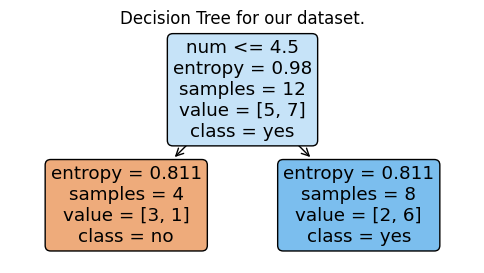

In [34]:
dc = DecisionTreeClassifier(max_depth=1, criterion='entropy')

dc.fit(df_balls[['num']], df_balls['color_label'])

# plot the DT
fig = plt.figure(figsize=(6, 3))
_ = tree.plot_tree(dc, 
                   feature_names=dc.feature_names_in_,  
                   class_names=['no', 'yes'],
                   filled=True, 
                   rounded=True)
plt.gca().set_title('Decision Tree for our dataset.');

In [35]:
gain(df_balls, 'num', 4, 'color_label')

gain(criterion='entropy', gain=0.16859063219201997, group_a_criterion=0.8112781244591328, group_b_criterion=0.8112781244591328, group_a_criterion_scaled=0.2704260414863776, group_b_criterionscaled=0.5408520829727552)

And what about categorical variables? What happens then?

Let's define augmented `df_balls` with one categorical variable, and check what happens then?

In [36]:
_balls = ['b', 'r', 'r', 'r', 'b', 'b', 'b', 'r', 'b', 'b', 'r', 'b']
_owner = ['jake', 'jake', 'jake', 'fin', 'fin', 'jake', 'fin', 'lsp', 'jake', 'lsp', 'lsp', 'lsp']
_num = list(range(12))

df_balls = pd.DataFrame(list(zip(_num, _owner, _balls)), columns=['num', 'owner', 'color'])#.rename(columns={'index': 'num', 0: 'color'})

df_balls['color_label'] = (df_balls['color'] == 'b').astype('int')

df_balls

,num,owner,color,color_label
0,0,jake,b,1
1,1,jake,r,0
2,2,jake,r,0
3,3,fin,r,0
4,4,fin,b,1
5,5,jake,b,1
6,6,fin,b,1
7,7,lsp,r,0
8,8,jake,b,1
9,9,lsp,b,1


Alright, let's do the the same steps, but for categorical variable `owner` now.

In [37]:
for i in df_balls['owner'].unique():
    _, ig, _, _ ,_, _ = gain(df_balls, 'owner', i, 'color_label')
    print(f'If we split num at {i:>2} then IG={ig:.3f}')

If we split num at jake then IG=0.001
If we split num at fin then IG=0.007
If we split num at lsp then IG=0.010


However, `sklearn's DecisionTreeClassifier` doesn't work with categorical predictors. We have to encode them somehow. Here, we will encode it by using `LabelEncoder`.

In [38]:
le = LabelEncoder()

le.fit(df_balls['owner'])

LabelEncoder()

In [39]:
le.classes_

array(['fin', 'jake', 'lsp'], dtype=object)

In [40]:
df_balls['owner_le'] = le.transform(df_balls['owner'])

In [41]:
df_balls

,num,owner,color,color_label,owner_le
0,0,jake,b,1,1
1,1,jake,r,0,1
2,2,jake,r,0,1
3,3,fin,r,0,0
4,4,fin,b,1,0
5,5,jake,b,1,1
6,6,fin,b,1,0
7,7,lsp,r,0,2
8,8,jake,b,1,1
9,9,lsp,b,1,2


In [42]:
for i in df_balls['owner_le'].unique():
    _, ig, _, _ ,_, _ = gain(df_balls, 'owner_le', int(i), 'color_label')
    print(f'If we split num at {i:>2} then IG={ig:.3f}')

If we split num at  1 then IG=0.010
If we split num at  0 then IG=0.007
If we split num at  2 then IG=0.000


Pay attention, how `DecisionTreeClassifier` uses labels for splitting dataset into subsets is a bit different than how our function did it.

It says that label encoded `owner=jake` is the best split, and it goes to say that one subset should contain only values **fin** and **jake**, while other should contain only value **lsp** of categorical variable. This is in essence what our function returned as the best split. 

Let's see.

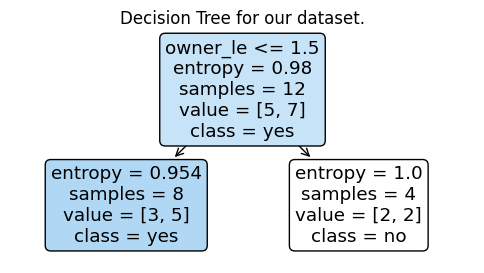

In [43]:
dc = DecisionTreeClassifier(max_depth=1, criterion='entropy', )

dc.fit(df_balls[['owner_le']], df_balls['color_label'])

# plot the DT
fig = plt.figure(figsize=(6, 3))
_ = tree.plot_tree(dc, 
                   feature_names=dc.feature_names_in_,  
                   class_names=['no', 'yes'],
                   filled=True, 
                   rounded=True)

plt.gca().set_title('Decision Tree for our dataset.');

In [44]:
df_balls['owner_le'].values

array([1, 1, 1, 0, 0, 1, 0, 2, 1, 2, 2, 2])

In [45]:
le.inverse_transform(df_balls['owner_le'])

array(['jake', 'jake', 'jake', 'fin', 'fin', 'jake', 'fin', 'lsp', 'jake',
       'lsp', 'lsp', 'lsp'], dtype=object)

In [46]:
gain(df_balls, 'owner', 'lsp', 'color_label')

gain(criterion='entropy', gain=0.010246088034509437, group_a_criterion=1.0, group_b_criterion=0.954434002924965, group_a_criterion_scaled=0.3333333333333333, group_b_criterionscaled=0.63628933528331)

Before we wrap up with entropy and information gain based on it, let's see what happens when there are multiple columns of different types. What happens then?

Well, algorithm goes and repeats the process of searching for best split, looking at each predictor and it's values.

Something like this.

In [47]:
df_balls

,num,owner,color,color_label,owner_le
0,0,jake,b,1,1
1,1,jake,r,0,1
2,2,jake,r,0,1
3,3,fin,r,0,0
4,4,fin,b,1,0
5,5,jake,b,1,1
6,6,fin,b,1,0
7,7,lsp,r,0,2
8,8,jake,b,1,1
9,9,lsp,b,1,2


We are going to use `num` and `owner_le` columns as predictors.

In [48]:
_results = []

for column in ['num', 'owner_le']:
    for i in df_balls[column].unique():
        _, ig, _, _ ,_, _ = gain(df_balls, column, int(i), 'color_label')
        print(f'If we split dataset on {column} at {i:>2} then IG={ig:.3f}')
        _results.append({'ig': ig, 'column': column, 'threshold': int(i)})

If we split dataset on num at  0 then IG=0.069
If we split dataset on num at  1 then IG=0.004
If we split dataset on num at  2 then IG=0.062
If we split dataset on num at  3 then IG=0.169
If we split dataset on num at  4 then IG=0.072
If we split dataset on num at  5 then IG=0.021
If we split dataset on num at  6 then IG=0.001
If we split dataset on num at  7 then IG=0.043
If we split dataset on num at  8 then IG=0.007
If we split dataset on num at  9 then IG=0.004
If we split dataset on num at 10 then IG=0.069
If we split dataset on num at 11 then IG=0.000
If we split dataset on owner_le at  1 then IG=0.010
If we split dataset on owner_le at  0 then IG=0.007
If we split dataset on owner_le at  2 then IG=0.000


In [49]:
pd.DataFrame(_results).sort_values(by='ig', ascending=False).iloc[0]

ig           0.168591
column            num
threshold           3
Name: 3, dtype: object

And how does `DecisionTreeClassifier` works in this case?

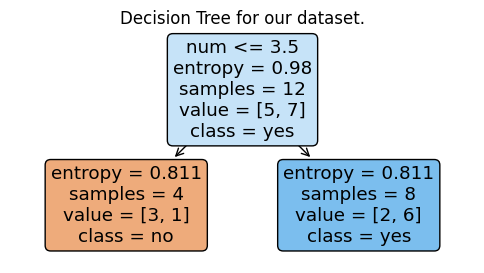

In [50]:
dc = DecisionTreeClassifier(max_depth=1, criterion='entropy', )

dc.fit(df_balls[['num', 'owner_le']], df_balls['color_label'])

# plot the DT
fig = plt.figure(figsize=(6, 3))
_ = tree.plot_tree(dc, 
                   feature_names=dc.feature_names_in_,  
                   class_names=['no', 'yes'],
                   filled=True, 
                   rounded=True)

plt.gca().set_title('Decision Tree for our dataset.');

After all of this, we are here because of predictions and measuring how model performs, right?

In [51]:
balls_predictions = dc.predict(df_balls[['num', 'owner_le']])
balls_predictions

array([0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1])

In [52]:
print(classification_report(df_balls['color_label'], balls_predictions))

              precision    recall  f1-score   support

           0       0.75      0.60      0.67         5
           1       0.75      0.86      0.80         7

    accuracy                           0.75        12
   macro avg       0.75      0.73      0.73        12
weighted avg       0.75      0.75      0.74        12



In [53]:
confusion_matrix(df_balls['color_label'], balls_predictions)

array([[3, 2],
       [1, 6]])

This checks. We have figured the way decision tree is constructed! 

But, wait! Is this the end?

No.

This is just the first step. After this, we go and perform the same process on each of new nodes, and keep doing this until we end up with nodes with entropy 0. That is, when each of the leafs in our tree contains only observations of the same class.

How is this done?

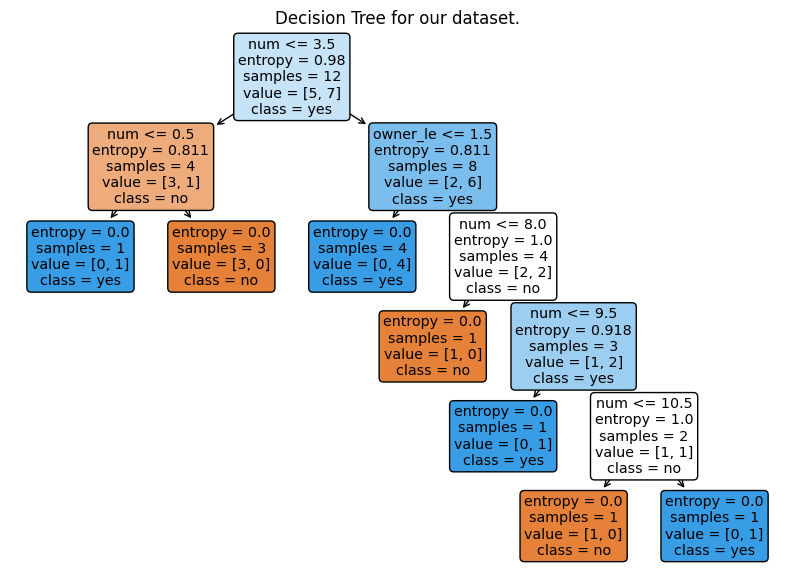

In [54]:
dc = DecisionTreeClassifier(criterion='entropy')

dc.fit(df_balls[['num', 'owner_le']], df_balls['color_label'])

# plot the DT
fig = plt.figure(figsize=(10, 7))
_ = tree.plot_tree(dc, 
                   feature_names=dc.feature_names_in_,  
                   class_names=['no', 'yes'],
                   filled=True, 
                   rounded=True)

plt.gca().set_title('Decision Tree for our dataset.');

From this example we can see that leafs have entropy of 0, either with one or more observations of the same class, in this case color.

One more thing.

Let's check this model's performance.

In [55]:
balls_predictions = dc.predict(df_balls[['num', 'owner_le']])
balls_predictions

array([1, 0, 0, 0, 1, 1, 1, 0, 1, 1, 0, 1])

In [56]:
print(classification_report(df_balls['color_label'], balls_predictions))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00         5
           1       1.00      1.00      1.00         7

    accuracy                           1.00        12
   macro avg       1.00      1.00      1.00        12
weighted avg       1.00      1.00      1.00        12



In [57]:
confusion_matrix(df_balls['color_label'], balls_predictions)

array([[5, 0],
       [0, 7]])

What? This model has 100% accuracy. 

How would `LogisticRegression` perform in this case?

In [58]:
lr = LogisticRegression()
lr.fit(df_balls[['num', 'owner_le']], df_balls['color_label'])

balls_predictions = lr.predict(df_balls[['num', 'owner_le']])


In [59]:
print(classification_report(df_balls['color_label'], balls_predictions))

              precision    recall  f1-score   support

           0       0.67      0.40      0.50         5
           1       0.67      0.86      0.75         7

    accuracy                           0.67        12
   macro avg       0.67      0.63      0.62        12
weighted avg       0.67      0.67      0.65        12



In [60]:
confusion_matrix(df_balls['color_label'], balls_predictions)

array([[2, 3],
       [1, 6]])

Decision trees to the rescue!!!

### Gini impurity

So far we went into information theory to pick up exceptionally important concepts of self-information and entropy, and defined information entropy and information gain as a way to decide how to partition our dataset.

However, entropy is not the only approach in defining how informative our splits can be. Here, we will shortly define another way, namely **Gini impurity**.

This approach approaches the problem from the different angle. Here, we want to measure probability of classifying observation incorrectly.

Let's make this very clear with simple with an example. Again, we are going to resort to our good ole' friend coin. We are almost out of coins. Joking.

If we have a fair coin, and flip it, but in the mean time try to predict the outcome, what is a probability of predicting it correctly?

Well, there are 4 possible results:
- Outcome: H, Prediction: H, probability .5 * .5 = .25
- Outcome: T, Prediction: H, probability .5 * .5 = .25
- Outcome: H, Prediction: T, probability .5 * .5 = .25
- Outcome: T, Prediction: T, probability .5 * .5 = .25


Well, apparently the probability of predicting the outcome correctly is 50%.

We can define Gini impurity $G$ as:

$$ G(X) = \sum_{i=1}^{x}{p_i * (1 - p_i)},$$

where $X$ is a discrete random variable, and $x$ is the number of different possible states that random variable can have.

After fiddling a bit with this expression you get the next one:

$$ G(X) = 1 - \sum_{i=1}^{x}{p_{i}^2}.$$

More precisely, Gini impurity measures how often a randomly chosen element would be classified incorrectly if it was labeled randomly and indepenendly with distribution of labels in mind. 

In case of a coin flip, distribution is Bernoulli with $p=.5$. Anyway, Gini can be used for a discrete random variable with more than 2 outcomes just as easily.

Let's define Gini impurity helper function.


In [61]:
def gini_basic(p):
    return 1 - np.sum(np.array(p)**2)

In [62]:
gini_basic([.5, .5])

0.5

How about we do the same thing for Gini impurity, as we did with entropy. Let's plot Gini impurity as a function of probability p, for the case of coin.

Also, let's compare entropy with Gini impurity at the same time.

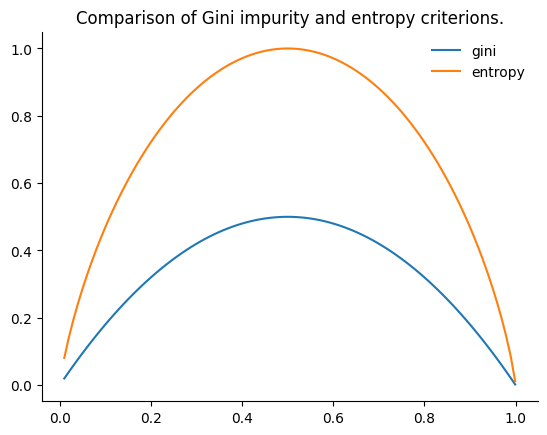

In [63]:
x = np.linspace(0.01, 0.999, 100)

y_gini = list(map(gini_basic, list(zip(x, 1-x))))
y_entropy = list(map(entropy_basic, list(zip(x, 1-x))))

plt.plot(x, y_gini, label='gini')
plt.plot(x, y_entropy, label='entropy')
sns.despine()
plt.legend(frameon=False)
plt.title('Comparison of Gini impurity and entropy criterions.');

You can see that Gini impurity and entropy are very similar, with entropy being 2 times the value of Gini impurity.

Now we will define `gini` function that will receive a sequence of events as an array, calculate probability of each event occuring and getting the Gini impurity based on this.

In [64]:
def gini(x):
    _, counts = np.unique(x, return_counts=True)
    p = counts/np.sum(counts)
    return 1 - np.sum(np.array(p)**2)

### Gini impurity

Just as we did introduce information gain based on entropy, we can introduce **Gini gain** based on Gini impurity.

If we have a dataset that is being split into two subsets based on some value of random variable $X$, then Gini gain is defined as:

$$ GG(X) = G_0 - \sum_{i=1}^{x}{\frac{N_i}{N}*G_i}.$$

Here $G_0$ is the Gini impurity of the original dataset, while $G_i$ is Gini impurity of each subset. $N_i$ is the cardinality of each of subsets. This is all the same as we did for information gain.


Let's do the same experiments as we did with information gain.

In [65]:
df_balls

,num,owner,color,color_label,owner_le
0,0,jake,b,1,1
1,1,jake,r,0,1
2,2,jake,r,0,1
3,3,fin,r,0,0
4,4,fin,b,1,0
5,5,jake,b,1,1
6,6,fin,b,1,0
7,7,lsp,r,0,2
8,8,jake,b,1,1
9,9,lsp,b,1,2


In [66]:
gain(df_balls, 'num', 5, 'color_label', criterion=gini)

gain(criterion='gini', gain=0.01388888888888884, group_a_criterion=0.5, group_b_criterion=0.4444444444444444, group_a_criterion_scaled=0.25, group_b_criterionscaled=0.2222222222222222)

Alright, and what about we search for the best value for the split, using both columns as we did before?

In [67]:
_results = []

for column in ['num', 'owner_le']:
    for i in df_balls[column].unique():
        _, ig, _, _ ,_, _ = gain(df_balls, column, int(i), 'color_label', criterion=gini)
        print(f'If we split dataset on {column} at {i:>2} then IG={ig:.3f}')
        _results.append({'ig': ig, 'column': column, 'threshold': int(i)})

If we split dataset on num at  0 then IG=0.032
If we split dataset on num at  1 then IG=0.003
If we split dataset on num at  2 then IG=0.042
If we split dataset on num at  3 then IG=0.111
If we split dataset on num at  4 then IG=0.048
If we split dataset on num at  5 then IG=0.014
If we split dataset on num at  6 then IG=0.000
If we split dataset on num at  7 then IG=0.028
If we split dataset on num at  8 then IG=0.005
If we split dataset on num at  9 then IG=0.003
If we split dataset on num at 10 then IG=0.032
If we split dataset on num at 11 then IG=0.000
If we split dataset on owner_le at  1 then IG=0.007
If we split dataset on owner_le at  0 then IG=0.005
If we split dataset on owner_le at  2 then IG=0.000


And how about we let `DecisionTreeClassifier` do the splitting?

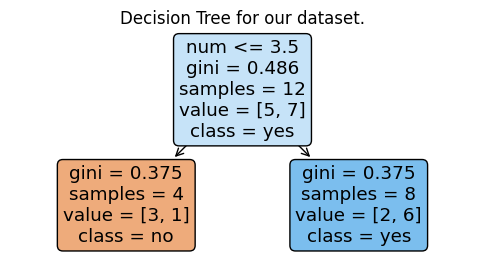

In [68]:
dc = DecisionTreeClassifier(max_depth=1, criterion='gini', )

dc.fit(df_balls[['num', 'owner_le']], df_balls['color_label'])

# plot the DT
fig = plt.figure(figsize=(6, 3))
_ = tree.plot_tree(dc, 
                   feature_names=dc.feature_names_in_,  
                   class_names=['no', 'yes'],
                   filled=True, 
                   rounded=True)

plt.gca().set_title('Decision Tree for our dataset.');

In [69]:
gain(df_balls, 'num', 3, 'color_label', criterion=gini)

gain(criterion='gini', gain=0.11111111111111105, group_a_criterion=0.375, group_b_criterion=0.375, group_a_criterion_scaled=0.125, group_b_criterionscaled=0.25)

This checks out too! Great. We introduced important concepts and implemented simple splitting while optimizing for both information and Gini gains.

For the very end, let's grow decision tree once more, and plot the predictions.

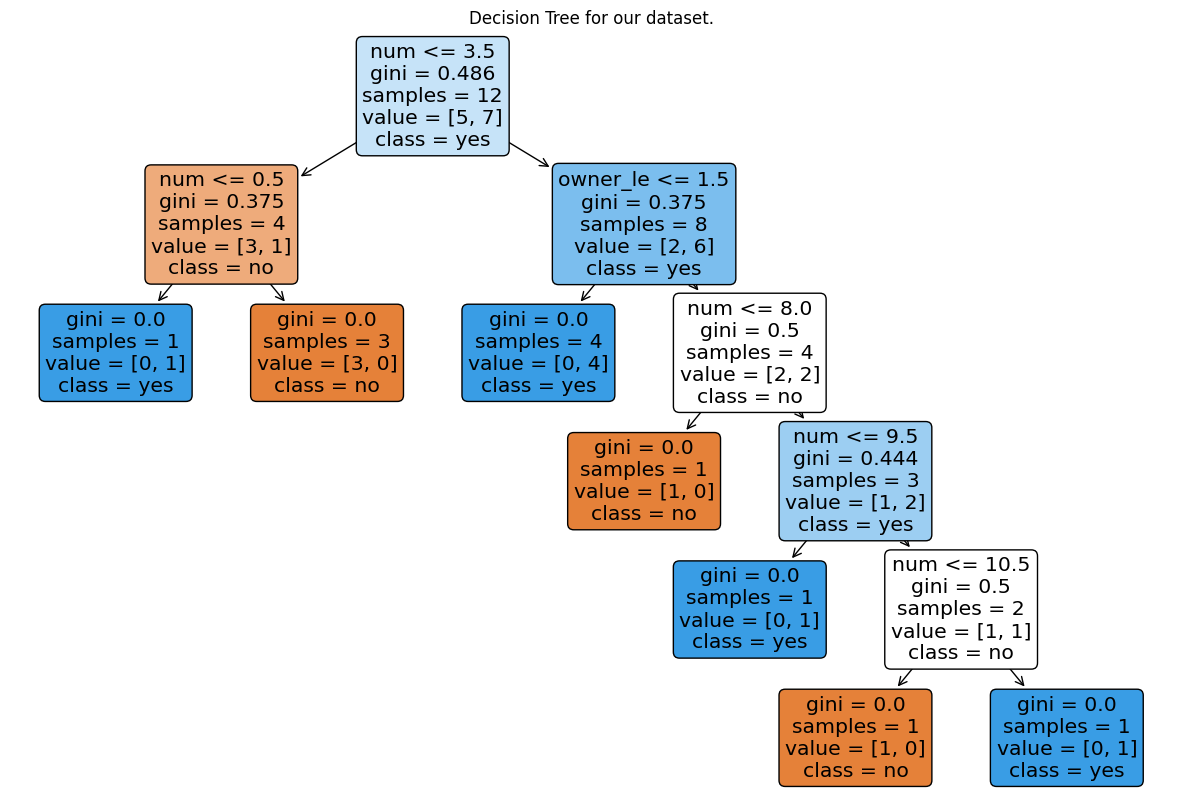

In [70]:
dc = DecisionTreeClassifier(criterion='gini')

dc.fit(df_balls[['num', 'owner_le']], df_balls['color_label'])

# plot the DT
fig = plt.figure(figsize=(15, 10))
_ = tree.plot_tree(dc, 
                   feature_names=dc.feature_names_in_,  
                   class_names=['no', 'yes'],
                   filled=True, 
                   rounded=True)

plt.gca().set_title('Decision Tree for our dataset.');

And how about we see how decision tree partitions predictor space?

![](_img/decision_tree_regions.png)

### Regression and reduction of variance




As we mentioned at the beginning of this session, we wanted to show how decision trees can be used to solve classification problems. And this is what intuitively makes a lot of sence. And you have seen that we we able to switch between optimization functions, like information or gini gain, and decide how to partition our data based on results of these functions.

However, even though decision trees intuitively fit in the scenario of decision making, and therefore are are easy to apply in classification problems, there is a way to use them in regression type of problems as well. When used with specific optimization functions tailored for continuous perdictors, we call these **Regression trees**.

Here we are going to go straight into an example defining a toy dataset, and try explain how we can use regression trees to predict numerical predictor variable.

First, we want to define a dataset. Let's try to decribe salary/monthly income/pension as a function of age, meausred in 10k units. We will add sex as a flag, just to see how categorical features can be used in regression trees.

In [71]:
_age = [18, 19, 20, 25, 27, 28, 30, 32, 22, 33, 36, 45, 44, 50, 60, 51, 54, 63, 67, 55, 66, 70, 71, 68]
_income = [1, .5, 1.1, 2, 2, 2, 2.5, 2.6, 2, 2, 2.4, 4.2, 4, 4.8, 4, 3, 5, 5, 4.5, 2, 2, 1.5, 1.2, 1]
_sex = ['m', 'f', 'f', 'f', 'm', 'm', 'm', 'f', 'm', 'f', 'f', 'f', 'm', 'm', 'm', 'f', 'f', 'f', 'f', 'f', 'm', 'm', 'f', 'f']

df_income = pd.DataFrame(list(zip(_age, _income, _sex)), columns=['age', 'income', 'sex'])
df_income.head()

,age,income,sex
0,18,1.0,m
1,19,0.5,f
2,20,1.1,f
3,25,2.0,f
4,27,2.0,m


In [72]:
def plot_regression(df):
    fig, ax = plt.subplots(nrows=1, ncols=3, figsize=(15, 4))
    sns.scatterplot(x='age', y='income', data=df, ax=ax[0])
    sns.despine(ax=ax[0])
    ax[0].set_title('Scatter plot for our observations.');

    sns.regplot(x='age', y='income', data=df, ax=ax[1])
    sns.despine(ax=ax[1])
    ax[1].set_title('Regression plot for our observations.');

    sns.residplot(x='age', y='income', data=df, ax=ax[2])
    sns.despine(ax=ax[2])
    ax[2].set_title('Residuals plot for our observations.');


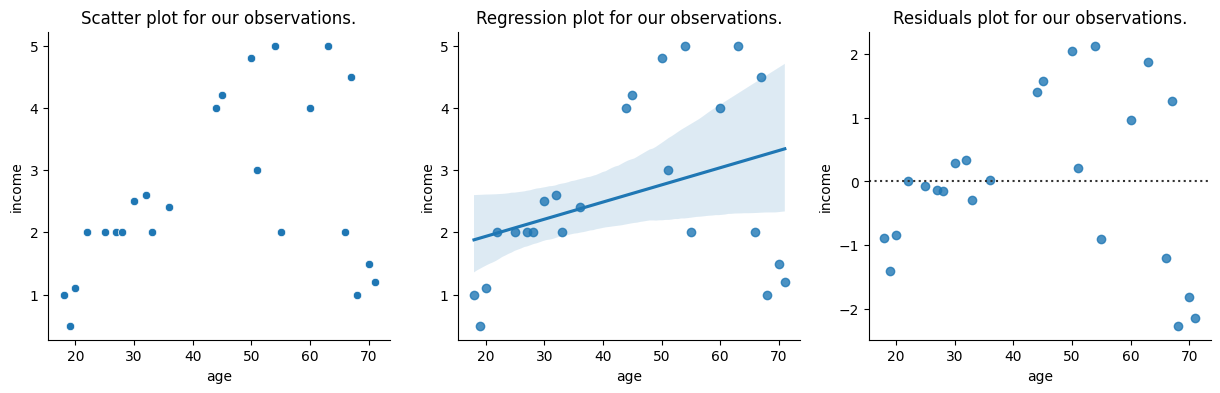

In [73]:
plot_regression(df_income)

Now comes the interesting part. Do you remember what we did optimize for when we went over the theory behind linear regression. $SSE$ right? Sum of squared errors.

If we said that $y_i$ is the value we are predicting, and $\hat{y_i}$ is the prediction, then for $N$ number of observations, we defined $SSE$ as:

$$SSE = \sum_{i=1}^{N}{(y_i - \hat{y_i})^2}.$$

We also said that by this definition of optimization function we ensured that we will always be able to find minimum, at which point all parameters of the model would be the ones that are the solution to the problem.

So the question is, can we use this for regression trees? 

The answer is yes!

We start as we did with decision trees, by splitting dataset at some predictor's value and then we will get the $SSE$ for each set's predicted variable. 

But wait! What is the prediction in this case, the $\hat{y_i}$? Well, we will use arithmetic mean as our best guess. So, in essence, what we are doing is we are measuring dispersion in each set, right?

In [74]:
def sse(x):
    # dividing by the size of set is just to make
    # results compatibile with sklearn's results
    # it doesn't affect how minimum is found
    return np.sum((x - np.mean(x))**2)/len(x)

What would be the $SSE$ of our dataset?

In [75]:
sse(df_income['income'].values)

1.838732638888889

Alright! And what about we use `age` at value 30, as a threshold for splitting the dataset, and then get the $SSE$ of predictor variable for each?

In [76]:
_df_income_a = df_income.loc[df_income['age'] <= 30, 'income']

_income_sse_a= sse(_df_income_a)
_income_sse_a

0.40734375

In [77]:
_df_income_b = df_income.loc[df_income['age'] > 30, 'income']

_income_sse_b = sse(_df_income_b)
_income_sse_b 

1.865625

What about the average value? Remember we have to account for the size of each subset when we perform averaging.

In [78]:
_income_sse_a * len(_df_income_a)/len(df_income) + _income_sse_b * len(_df_income_b)/len(df_income)

1.37953125

Apparently, sum of these errors is smaller in value than the $SSE$ error of the original dataset.

Now, let's go over all values of `age` and get the combined $SSE$ of subsets.

In [79]:
_results = []

# pay attention to [:-1]
for a in sorted(df_income['age'].values)[:-1]:
    _df_income_a = df_income.loc[df_income['age'] <= a, 'income']
    _income_sse_a = sse(_df_income_a)

    _df_income_b = df_income.loc[df_income['age'] > a, 'income']
    _income_sse_b = sse(_df_income_b)

    _results.append({'age': a, 'sse' : _income_sse_a * (len(_df_income_a)/len(df_income)) + _income_sse_b * (len(_df_income_b)/len(df_income))})

We want to get the results in a DataFrame and then plot these for analysis.

In [80]:
_df_results = pd.DataFrame(_results)

_sse = np.array(list(map(lambda x: x['sse'], _results)))
_idx = np.argmin(_sse)

In [81]:
_df_results.head()

,age,sse
0,18,1.728007
1,19,1.528996
2,20,1.411587
3,22,1.420646
4,25,1.410377


In [82]:
# best performing threshold value and it's SSE value
df_income['age'].iloc[_idx], _sse[_idx]

(36, 1.338921911421911)

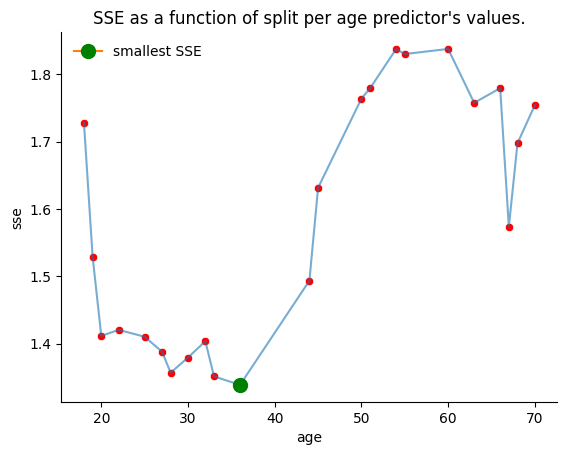

In [83]:
sns.lineplot(x='age', y='sse', data=_df_results, alpha=.6)
sns.scatterplot(x='age', y='sse', data=_df_results, color='red')
plt.plot(df_income['age'].iloc[_idx], 
         _sse[_idx], 
         marker='.',
         markersize=20, 
         markerfacecolor='green', 
         markeredgecolor='green', 
         label='smallest SSE')
sns.despine()
plt.legend(frameon=False)
plt.title('SSE as a function of split per age predictor\'s values.');

And how about we use `sklearn's DecisionTreeRegressor` to see how we are doing with our science?

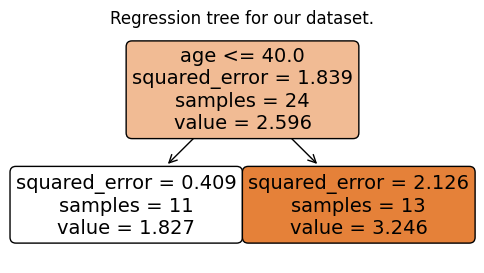

In [84]:
dc = DecisionTreeRegressor(max_depth=1, criterion='squared_error')

dc.fit(df_income[['age']], df_income['income'])

# plot the DT
fig = plt.figure(figsize=(6, 3))
_ = tree.plot_tree(dc, 
                   feature_names=dc.feature_names_in_,  
                   class_names=['no', 'yes'],
                   filled=True, 
                   rounded=True)

plt.gca().set_title('Regression tree for our dataset.');

As you can see, `DecisionTreeClassifier` and `DecisionTreeRegressor` are using some provisional threshold values that are somewhere in between existing values. This is the part of an internal logic and heuristic. In our case value of 40 doesn't exist, but next value that is smaller than 40 is exactly 36, and this is something our algorithm found to be the best threshold for splitting.

How about we check these results and compare them to our `gain` function results?

In [85]:
# great
sse(df_income['income'].values)

1.838732638888889

In [86]:
# great
sse(df_income.loc[df_income['age'] <= 40, 'income'])

0.40925619834710747

In [87]:
# great
sse(df_income.loc[df_income['age'] > 40, 'income'])

2.1255621301775145

In [88]:
gain(df_income, 'age', 40, 'income', criterion=sse)

gain(criterion='sse', gain=0.49981072746697786, group_a_criterion=0.40925619834710747, group_b_criterion=2.1255621301775145, group_a_criterion_scaled=0.1875757575757576, group_b_criterionscaled=1.1513461538461536)

And what about we do test all predictors for best threshold value?

In [89]:
_results = []

for column in ['age', 'sex']:
    for i in list(df_income[column].unique()):
        _, ig, _, _ ,_, _ = gain(df_income, column, i, 'income', criterion=sse)
        print(f'If we split dataset on {column} at {i:>2} then IG={ig:.3f}')
        _results.append({'ig': ig, 'column': column, 'threshold': i})

If we split dataset on age at 18 then IG=0.111
If we split dataset on age at 19 then IG=0.310
If we split dataset on age at 20 then IG=0.427
If we split dataset on age at 25 then IG=0.428
If we split dataset on age at 27 then IG=0.450
If we split dataset on age at 28 then IG=0.482
If we split dataset on age at 30 then IG=0.459
If we split dataset on age at 32 then IG=0.435
If we split dataset on age at 22 then IG=0.418
If we split dataset on age at 33 then IG=0.487
If we split dataset on age at 36 then IG=0.500
If we split dataset on age at 45 then IG=0.207
If we split dataset on age at 44 then IG=0.345
If we split dataset on age at 50 then IG=0.075
If we split dataset on age at 60 then IG=0.001
If we split dataset on age at 51 then IG=0.060
If we split dataset on age at 54 then IG=0.001
If we split dataset on age at 63 then IG=0.081
If we split dataset on age at 67 then IG=0.265
If we split dataset on age at 55 then IG=0.009
If we split dataset on age at 66 then IG=0.060
If we split d

In [90]:
pd.DataFrame(_results).sort_values(by='ig', ascending=False).iloc[0]

ig           0.499811
column            age
threshold          36
Name: 10, dtype: object

Apparently `age` at `36` is the best threshold for splitting.

And now, we will plot regression analysis plots once more.

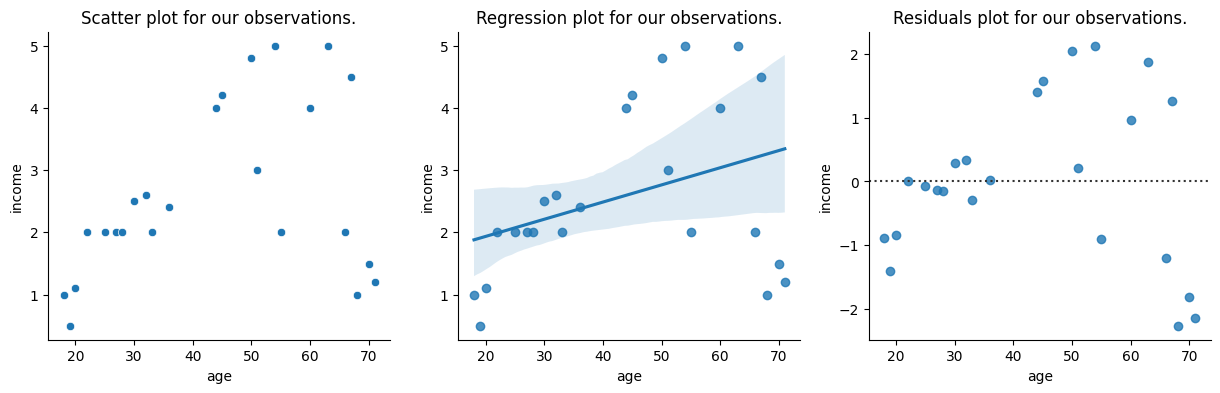

In [91]:
plot_regression(df_income)

And now let's train a tree regressor, plot it, and plot it's predictions.

In [92]:
df_income['sex_label'] = df_income['sex'] == 'f'

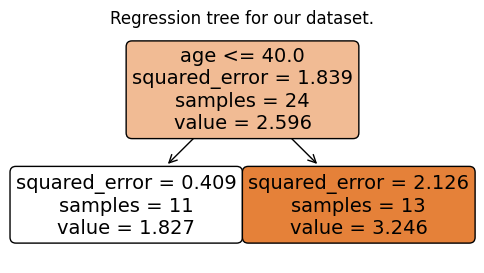

In [93]:
dc = DecisionTreeRegressor(max_depth=1, criterion='squared_error')

dc.fit(df_income[['age', 'sex_label']], df_income['income'])

# plot the DT
fig = plt.figure(figsize=(6, 3))
_ = tree.plot_tree(dc, 
                   feature_names=dc.feature_names_in_,  
                   class_names=['no', 'yes'],
                   filled=True, 
                   rounded=True)

plt.gca().set_title('Regression tree for our dataset.');

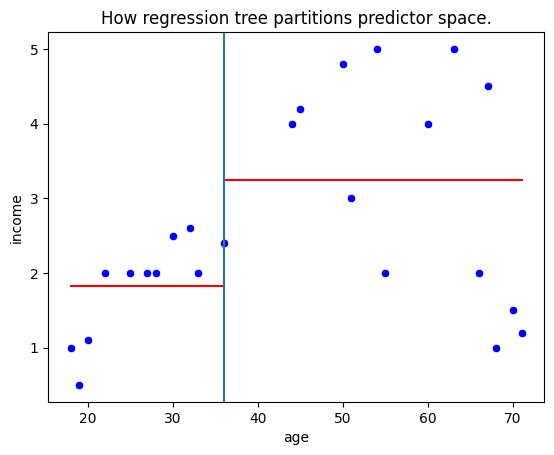

In [94]:
tree_predictions = dc.predict(df_income[['age', 'sex_label']])

sns.scatterplot(x=df_income['age'], y=df_income['income'], color='blue')
sns.lineplot(x=df_income['age'], y=tree_predictions, color='red', drawstyle='steps-pre');
plt.axvline(x=36)
plt.title('How regression tree partitions predictor space.');

What about assesing how our model performs?

In [95]:
income_predictions = dc.predict(df_income[['age', 'sex_label']])

In [96]:
r2_score(df_income['income'], income_predictions)

0.2718234923860403

Not that bad. Afteral, this is only one split we are talking about. 

And how would linear regression model perform on this dataset?

In [97]:
lr = LinearRegression()
lr.fit(df_income[['age', 'sex_label']], df_income['income'])

income_predictions = lr.predict(df_income[['age', 'sex_label']])

In [98]:
r2_score(df_income['income'], income_predictions)

0.13410497836055635

Regression tree is performing better. Nice. Seems like trees are better performers than linear models.

Now, for the wrap up, how about we let tree grow once again?

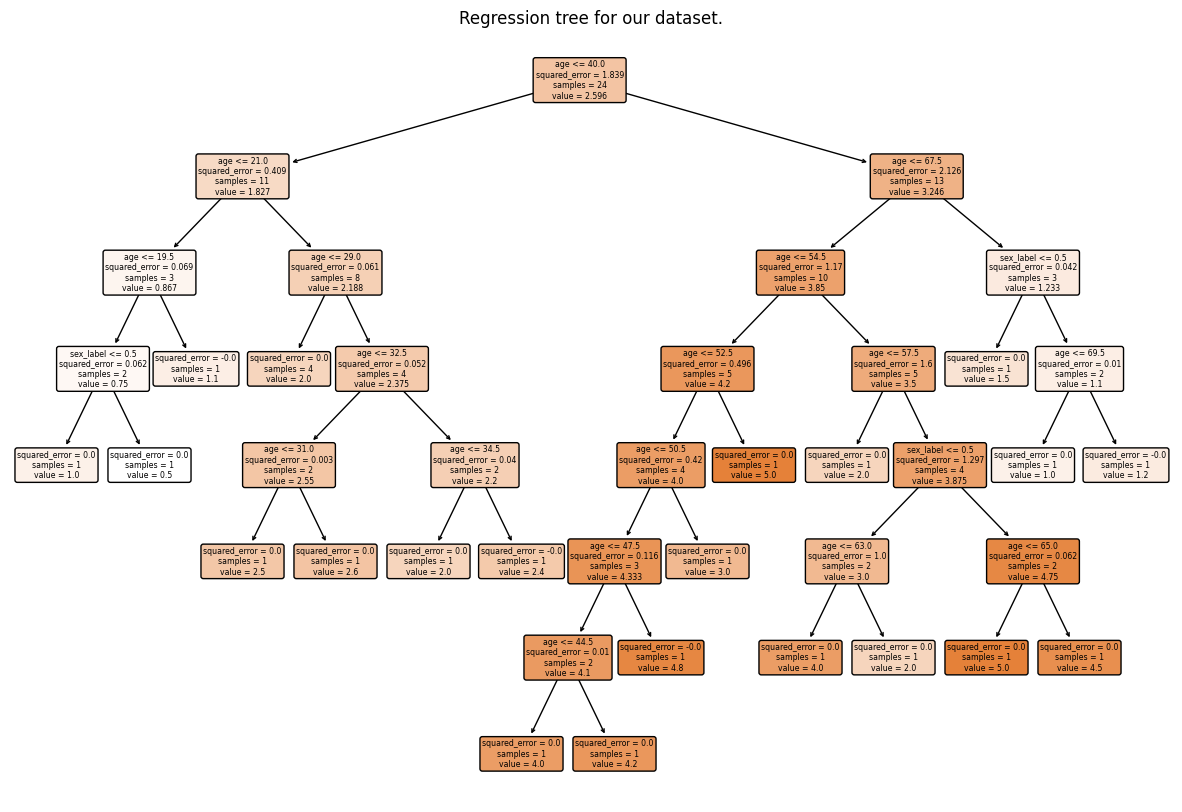

In [99]:
dc = DecisionTreeRegressor(criterion='squared_error')

dc.fit(df_income[['age', 'sex_label']], df_income['income'])

# plot the DT
fig = plt.figure(figsize=(15, 10))
_ = tree.plot_tree(dc, 
                   feature_names=dc.feature_names_in_,  
                   class_names=['no', 'yes'],
                   filled=True, 
                   rounded=True)

plt.gca().set_title('Regression tree for our dataset.');

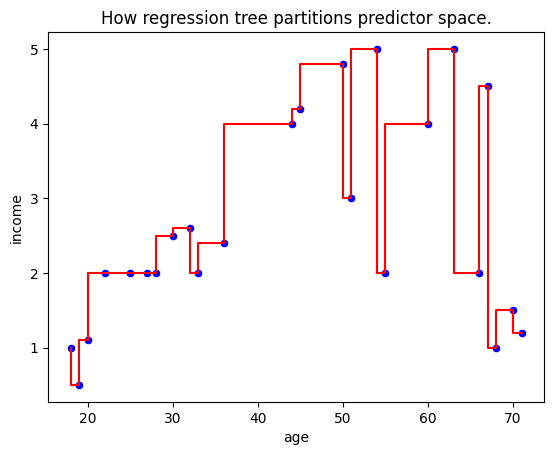

In [100]:
tree_predictions = dc.predict(df_income[['age', 'sex_label']])

sns.scatterplot(x=df_income['age'], y=df_income['income'], color='blue')
sns.lineplot(x=df_income['age'], y=tree_predictions, color='red', drawstyle='steps-pre');
plt.title('How regression tree partitions predictor space.');

In [101]:
income_predictions = dc.predict(df_income[['age', 'sex_label']])

In [102]:
r2_score(df_income['income'], income_predictions)

1.0

Well... model describes 100% of variability in data. Not that bad, right? Right? 

### Further Reading

- [Information Theory Basics](https://youtu.be/bkLHszLlH34)
- [A Short Introduction to Entropy, Cross-Entropy and KL-Divergence](https://youtu.be/ErfnhcEV1O8)
- [Decision Tree Classifier Python Code Example](https://vitalflux.com/decision-tree-classifier-python-code-example/)
- [SCIKIT-LEARN : DECISION TREE LEARNING II - CONSTRUCTING THE DECISION TREE](https://www.bogotobogo.com/python/scikit-learn/scikit_machine_learning_Constructing_Decision_Tree_Learning_Information_Gain_IG_Impurity_Entropy_Gini_Classification_Error.php)
- [Visualize a Decision Tree in 4 Ways with Scikit-Learn and Python](https://mljar.com/blog/visualize-decision-tree/)
- [Entropy (for data science) Clearly Explained!!!](https://www.youtube.com/watch?v=YtebGVx-Fxw&ab_channel=StatQuestwithJoshStarmer)




***

DataKolektiv, 2022/23.

[hello@datakolektiv.com](mailto:goran.milovanovic@datakolektiv.com)

![](../img/DK_Logo_100.png)

<font size=1>License: [GPLv3](https://www.gnu.org/licenses/gpl-3.0.txt) This Notebook is free software: you can redistribute it and/or modify it under the terms of the GNU General Public License as published by the Free Software Foundation, either version 3 of the License, or (at your option) any later version. This Notebook is distributed in the hope that it will be useful, but WITHOUT ANY WARRANTY; without even the implied warranty of MERCHANTABILITY or FITNESS FOR A PARTICULAR PURPOSE. See the GNU General Public License for more details. You should have received a copy of the GNU General Public License along with this Notebook. If not, see http://www.gnu.org/licenses/.</font>